# Serviceability limit state

Application example of SCI P354, *Design of Floors for Vibration* and comparison against a Footfall analysis with Robot Structural Analysis, as well as vibration results with Calculatis by Stora Enso.

## Simply supported uni-directional floor

This example consists on a simply supported uni-directional concrete floor on which a person is walking. The floor is analyzed as a one meter width simply supported beam and the walker's weight is distributed over the total floor width.

In [106]:
import numpy as np
import matplotlib.pyplot as plt

## Analysis definitions

In [107]:
t_end = 8  # s
sampling_points = 2000
gravity = 9.81  # m/s^2
t = np.linspace(0, t_end, sampling_points)
dt = t_end / sampling_points

## Structure properties

Using Rayleigh's method with an appropriate shape function corresponding for the first mode of vibration,
$$
\psi = \sin\left(\frac{\pi x}{L}\right)
$$
the modal stifness, mass and frequency read
$$
k = \int_0^L EI\psi''^2 dx = \frac{\pi^4EI}{2L^3} \quad \text{m/N per m width} \\
m = \int_0^L \rho A\psi^2 dx = \frac{\rho AL}{2} \quad \text{kg per m width} \\
\omega = \sqrt{\frac{k}{m}} = \frac{\pi^2}{L^2}\sqrt{\frac{EI}{\rho A}} \quad \text{rad/s}
$$

In [108]:
floor_span = 6  # m
floor_width = 1  # m
floor_thickness = 0.3  # m
imposed_load = 4000  # N/m^2
material_density = 2400  # kg/m^3
Young_modulus = 2.7e10  # Pa (concrete)
damping = 0.05  # %
inertia = 1 / 12 * floor_thickness**3  # m^4 per m width
linear_density = material_density * floor_thickness + imposed_load / gravity * floor_width  # kg/m
stiffness = 0.5 * np.pi**4 * Young_modulus * inertia / floor_span**3 * floor_width  # m/N
mass = 0.5 * linear_density * floor_span  # kg per m width
frequency = np.sqrt(stiffness / mass)  # rad/s
print(f'Floor frequency: {0.5*frequency/np.pi:.2f} Hz')

Floor frequency: 10.13 Hz


## Excitation

The nature of the excitation can be of different natures: walking, rythmic, indivudual or group. In this example, a single person walking is considered, which is the most common case for a residential area. The exitation function is defined using the a Fourier series decomposition, where the coefficients are defined in Table 3.1 of SCI P354.

Finally, the total time where the force is applied depends on the walking path length and the walking velocity. The walking velocity depends on the frequency according to the expression
$$
v = 1.67f^2 - 4.83*f + 4.5
$$

In [109]:
walker_weight = 76  # kg
natural_walking_frequency = 2  # Hz
walking_frequency = 2 * np.pi * natural_walking_frequency  # rad/s
walking_velocity = 1.67 * natural_walking_frequency**2 - 4.83 * natural_walking_frequency + 4.5  # m/s
walking_path_length = 5  # m
walking_time = walking_path_length / walking_velocity
walking_frequencies = [walking_frequency * ni for ni in [1, 2, 3, 4]]
f = walking_frequencies
a = []
a.append(0.436 * (1 * natural_walking_frequency - 0.95))
a.append(0.006 * (2 * natural_walking_frequency + 12.3))
a.append(0.007 * (3 * natural_walking_frequency + 5.20))
a.append(0.007 * (4 * natural_walking_frequency + 2.00))
p = [0, -0.5*np.pi, np.pi, 0.5*np.pi]
force = sum(walker_weight * gravity * ai * np.sin(fi * t + pi) for ai, fi, pi in zip(a, f, p))
force_total = sum([force, walker_weight * gravity * np.ones(sampling_points)])
print(f'Walking time: {walking_time:.2f} s')
print(f'Walking frequency: {natural_walking_frequency:.2f} Hz')
print(f'Walking velocity: {walking_velocity:.2f} m/s')
print(f'Fourier terms: {", ".join(f"{ai:.2f}" for ai in a)}')

Walking time: 3.29 s
Walking frequency: 2.00 Hz
Walking velocity: 1.52 m/s
Fourier terms: 0.46, 0.10, 0.08, 0.07


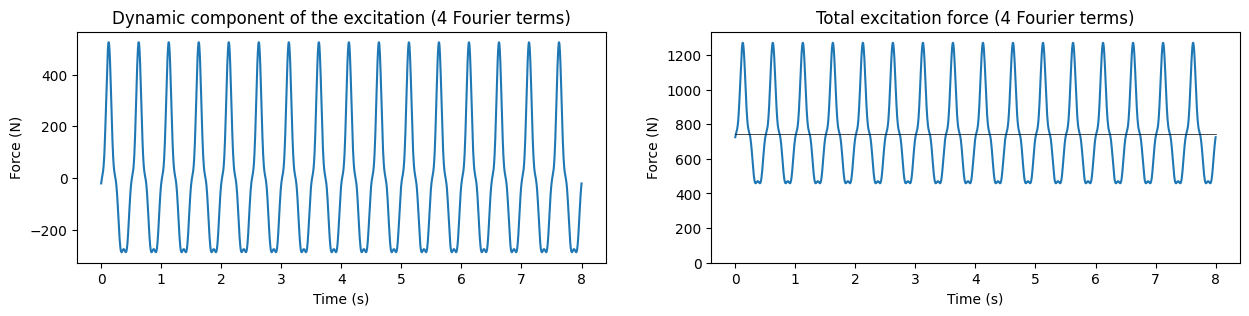

In [110]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(t, force)
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Dynamic component of the excitation (4 Fourier terms)')
plt.subplot(1,2,2)
plt.plot(t, force_total)
plt.plot([0, t_end], [walker_weight*gravity, walker_weight*gravity], color='black', lw=.5)
plt.ylim((0, 1.05*max(force_total)))
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Total excitation force (4 Fourier terms)')
plt.show()

## Weighting function

The weighting function represents the human sensitivity for the perception of different frequencies. This empirical function has the following form:

![image](img/weighting_curve_Wb.png)

$$
W_b = \begin{cases}
0.4 & 1 < f < 2 \ \text{Hz} \\
f/5 & 2 < f < 5 \ \text{Hz} \\
1.0 & 5 < f < 16 \ \text{Hz} \\
16/f & f > 16 \ \text{Hz}
\end{cases}
$$

Since the dynamic response of the excitation is the superposition of multiple frequencies, rather than multiplying the acceleration response by the weighting function, here we will multiply each component of the force by the corresponding weigthing value.

In [111]:
def Wb(frequency):
    f = 0.5 * frequency / np.pi
    if f < 2:
        return 0.4
    elif f < 5:
        return 0.2 * f
    elif f < 16:
        return 1.0
    else:
        return 16.0 / f

force = sum(walker_weight * gravity * ai * np.sin(fi * t + pi) * Wb(fi) for ai, fi, pi in zip(a, f, p))
force_total = sum([force, walker_weight * gravity * np.ones(sampling_points)])

## Stationary dynamic respone

The stationary (or resonant) response is obtained multiplying the static response by the dynamic magnification factor H and the weighting function W. After substitution, the starionary acceleration reads:

$$
a_{rms} = \psi_{e,n} \psi_{r,n} \frac{F a_h}{m_n \sqrt{2}}H_{a,h,n}W_{b,h}
$$

Where the subindex $h$ stands for the $i^{th}$ harmonic and $n$ stands for the $i^{th}$ mode of vibration. $\psi_e$ and $\psi_r$ are the shape functions evaluated at corresponding the excitation and response points. For this particular case, both excitation and response points are at the midspan and $\psi_e=\psi_r=1$. Finally, the dynamic magnification factor for accelerations is defined as

$$
H_a = \frac{\gamma^2}{\sqrt{(1-\gamma^2)^2 + 4\xi^2\gamma^2}}
$$

with $\gamma=\Omega_h/\omega_n$, where $\Omega_h$ is the excitation frequency for the $h^{th}$ harmonic and $\omega_n$ is the response frequency for the $n^{th}$ mode.

In [112]:
acc_stat = []
for ai, fi in zip(a, f):
    gi = fi / frequency
    H_ui = 1 / np.sqrt((1 - gi**2)**2 + 4 * damping**2 * gi**2)
    H_ai = gi**2 / np.sqrt((1 - gi**2)**2 + 4 * damping**2 * gi**2)
    a_stat_i = ai * walker_weight * gravity / mass * H_ai * Wb(fi)
    acc_stat.append(a_stat_i)
a_peak = sum(acc_stat)

## Impulsive response

When the natural frequency is much greater than the walking frequency ($f_1 > 4f_w$), the equivalent impulse is defined by the following empirical formula (SCI P354, Eq (18)):
$$
F_I = 60\frac{f_w^{1.43}}{f_1^{1.3}}\frac{Q}{700}
$$
where $f_w$ is the natural walking frequency, $f_1$ is the first natural frequency and $Q$ is an 'average person' weight, taken as $760N$.

Finally, the peak acceleration response for an impulsive excitation is
$$
a_{I,peak} = \omega_1 \frac{F_I}{m_1}
$$
This value may be multiplied by appropriate shape functions $\psi$ and weighting function W.

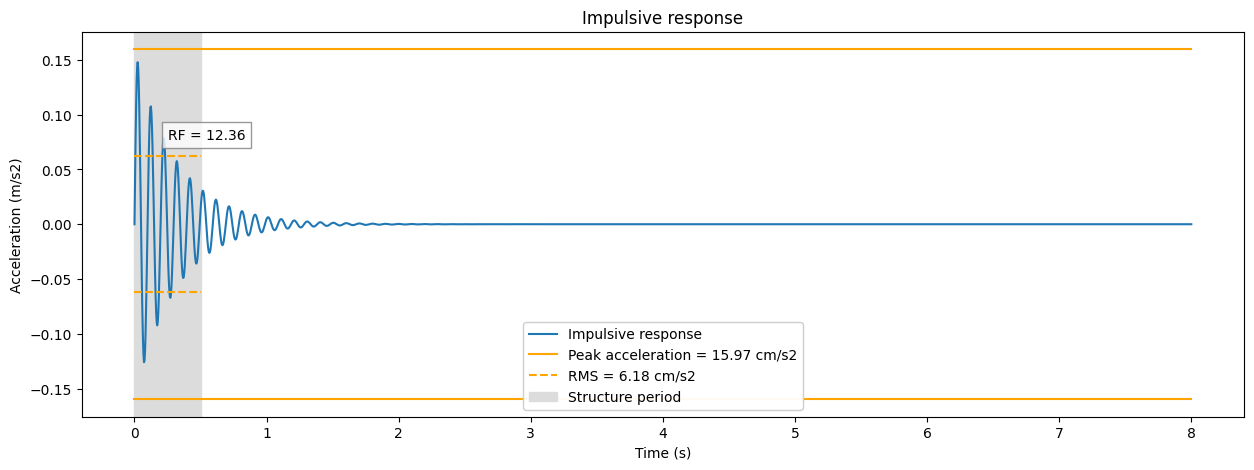

In [113]:
nat_fh = 0.5 * walking_frequency / np.pi
nat_f1 = 0.5 * frequency / np.pi
impulse = 60 * nat_fh**1.43 / nat_f1**1.3 * walker_weight * gravity / 700
a_peak_imp = frequency * impulse / mass
T_imp = 2 * np.pi / walking_frequency
a_imp = a_peak_imp * np.sin(frequency*t) * np.exp(-damping*frequency*t)
a_imp_transient_rms = a_imp[0:np.searchsorted(t, T_imp)]
a_rms_imp = np.sqrt(np.mean(a_imp_transient_rms**2))
RF_imp = a_rms_imp / 0.005
plt.figure(figsize=(15,5))
plt.plot(t,a_imp, label='Impulsive response')
plt.plot([0, t_end], [a_peak_imp, a_peak_imp], color='orange', label=f'Peak acceleration = {100*a_peak_imp:.2f} cm/s2')
plt.plot([0, t_end], [-a_peak_imp, -a_peak_imp], color='orange')
plt.plot([0, T_imp], [a_rms_imp, a_rms_imp], color='orange', ls='--', label=f'RMS = {100*a_rms_imp:.2f} cm/s2')
plt.plot([0, T_imp], [-a_rms_imp, -a_rms_imp], color='orange', ls='--')
plt.axvspan(0, T_imp, color='gainsboro', label='Structure period')
plt.text(0.5*T_imp, a_rms_imp+(a_peak_imp/10), f'RF = {RF_imp:.2f}', bbox=dict(alpha=.8, ec='gray', fc='white'))
plt.title('Impulsive response')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s2)')
plt.legend(framealpha=.95)
plt.show()

## Transient dynamic response
The transient dynamic response can be obtained by means of the Duhamel convolution
$$
u(t) = \frac{1}{m\omega} \int_0^t F(\tau) u_{free}(t-\tau) d\tau
$$
where the free response is given by
$$
u_{free}(t) = e^{-\xi\omega t}\sin(\omega t)
$$

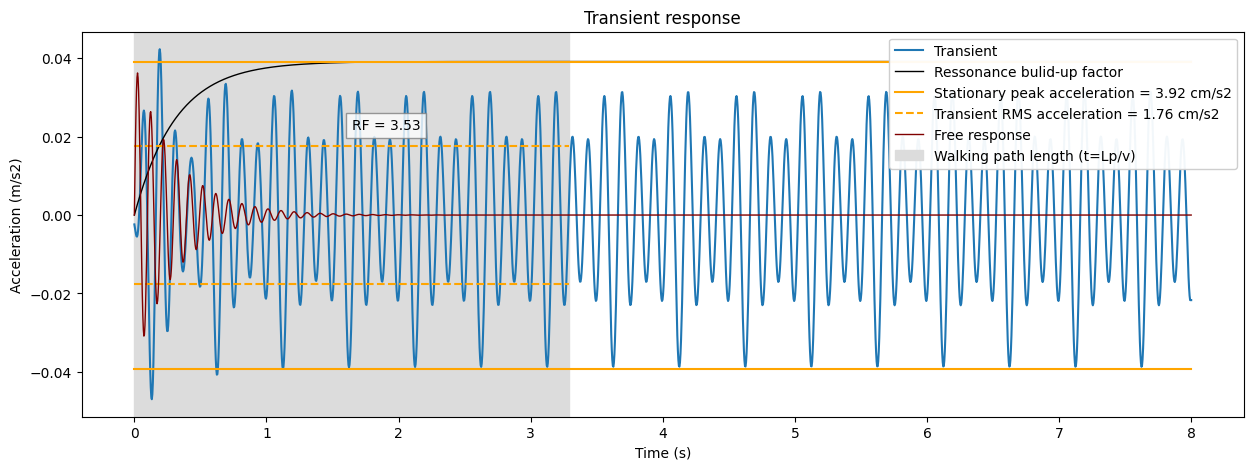

In [114]:
u_free = np.exp(-damping * frequency * t) * np.sin(frequency * t)
u_transient = np.convolve(force, u_free, 'full') * dt / mass / frequency
u_transient = u_transient[:len(u_transient)//2+1]
a_transient = np.diff(u_transient, 2) / dt**2
a_transient = np.append(a_transient, a_transient[-1])
a_transient = np.append(a_transient, a_transient[-1])
walking_end_idx = np.searchsorted(t, walking_time)
a_transient_rms = a_transient[0:walking_end_idx]
transient_factor_fct = 1 -np.exp(-damping * frequency * t)
transient_factor = transient_factor_fct[:walking_end_idx]
a_rms = np.sqrt(np.mean((a_transient_rms*transient_factor)**2))
a_max = max(a_transient)
plt.figure(figsize=(15,5))
plt.plot(t, a_transient, label='Transient')
plt.plot(t, transient_factor_fct * a_peak, 'black', lw=1, label='Ressonance bulid-up factor')
plt.plot([0, t_end], [a_peak, a_peak], 'orange', label=f'Stationary peak acceleration = {100*a_peak:.2f} cm/s2')
plt.plot([0, t_end], [-a_peak, -a_peak], 'orange')
plt.plot([0, walking_time], [a_rms, a_rms], 'orange', ls='--', label=f'Transient RMS acceleration = {100*a_rms:.2f} cm/s2')
plt.plot([0, walking_time], [-a_rms, -a_rms], 'orange', ls='--')
plt.plot(t, a_peak * u_free, color='maroon', lw=1, label='Free response')
plt.text(0.5*walking_time, a_rms+(a_max/10), f'RF = {a_rms/0.005:.2f}', bbox=dict(alpha=.8, ec='gray', fc='white'))
plt.axvspan(0, walking_time, color='gainsboro', label='Walking path length (t=Lp/v)')
plt.title('Transient response')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s2)')
plt.legend(loc='upper right', framealpha=.95)
plt.show()